### 1. Client erstellen

In [1]:
import os
from dotenv import load_dotenv
from edge_benchmarking_client.client import EdgeBenchmarkingClient

In [2]:
load_dotenv()

# Connection information
EDGE_FARM_API_PROTOCOL = os.getenv("EDGE_FARM_API_PROTOCOL")
EDGE_FARM_API_HOST = os.getenv("EDGE_FARM_API_HOST")

# Basic API authentication
EDGE_FARM_API_BASIC_AUTH_USERNAME = os.getenv("EDGE_FARM_API_BASIC_AUTH_USERNAME")
EDGE_FARM_API_BASIC_AUTH_PASSWORD = os.getenv("EDGE_FARM_API_BASIC_AUTH_PASSWORD")

# Create the client
client = EdgeBenchmarkingClient(
    protocol=EDGE_FARM_API_PROTOCOL,
    host=EDGE_FARM_API_HOST,
    username=EDGE_FARM_API_BASIC_AUTH_USERNAME,
    password=EDGE_FARM_API_BASIC_AUTH_PASSWORD,
)

2024-11-29 15:23:02.374 INFO client - __init__: Created Edge Benchmarking client for user 'admin' and Edge Farm at 'https://api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de'.
2024-11-29 15:23:02.423 INFO client - get_welcome_message: 200 - {'message': "Welcome to the REST API of AgrifoodTEF's Edge Benchmarking Service!"}
2024-11-29 15:23:02.424 INFO client - _test_connection: Edge Farm API at 'https://api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de' is reachable with status code 200.


### 2. Benchmark-Daten finden und einlesen

In [3]:
!rm -rf densenet_onnx/dataset/.ipynb_checkpoints
!rm -rf densenet_onnx/model/.ipynb_checkpoints

In [4]:
EXAMPLE_ROOT_DIR = "densenet_onnx"
DATASET_DIR = f"{EXAMPLE_ROOT_DIR}/dataset"
MODEL_DIR= f"{EXAMPLE_ROOT_DIR}/model"

dataset = client.find_dataset(
    root_dir=DATASET_DIR, file_extensions={".jpg", ".jpeg", ".JPG", ".JPEG", ".png", ".PNG"}
)
model = client.find_model(root_dir=MODEL_DIR)
model_metadata = client.find_model_metadata(root_dir=MODEL_DIR)
labels = client.find_labels(root_dir=MODEL_DIR)

2024-11-29 15:23:04.032 INFO client - find_dataset: Found dataset containing 50 samples with type(s) {'.JPG', '.jpg', '.JPEG', '.png', '.PNG', '.jpeg'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/dataset'.
2024-11-29 15:23:04.035 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_onnx.onnx' with extension {'.pt', '.pth', '.onnx'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-11-29 15:23:04.037 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/config.pbtxt' with extension {'.pbtxt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-11-29 15:23:04.040 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_labels.txt' with extension {'.txt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_

### 3. Benchmark-Job starten und auf Ergebnisse warten

In [ ]:
from edge_benchmarking_types.edge_farm.models import TritonDenseNetClient

EDGE_DEVICE_HOST="edge-03"

inference_client = TritonDenseNetClient(
    protocol="http",
    host=EDGE_DEVICE_HOST,
    port=8000,
    num_workers=1,
    samples_per_second=10,
    warm_up=False,
    model_name=EXAMPLE_ROOT_DIR,
    batch_size=1,
    num_classes=1000,
    scaling="inception",
)

benchmark_job = client.benchmark(
    edge_device=EDGE_DEVICE_HOST,
    dataset=dataset,
    model=model,
    model_metadata=model_metadata,
    labels=labels,
    inference_client=inference_client,
    chunk_size=10,
    cpu_only=False,
    cleanup=True,
)

2024-11-29 15:23:04.970 INFO client - upload_benchmark_data: 200 - bucket_name='d86a25ed-4966-4fb1-817e-d17cb33a6138' dataset=['dataset/ILSVRC2012_test_00011512.JPEG', 'dataset/ILSVRC2012_test_00011532.JPEG', 'dataset/ILSVRC2012_test_00011492.JPEG', 'dataset/ILSVRC2012_test_00011491.JPEG', 'dataset/ILSVRC2012_test_00011527.JPEG', 'dataset/ILSVRC2012_test_00011531.JPEG', 'dataset/ILSVRC2012_test_00011503.JPEG', 'dataset/ILSVRC2012_test_00011506.JPEG', 'dataset/ILSVRC2012_test_00011509.JPEG', 'dataset/ILSVRC2012_test_00011511.JPEG', 'dataset/ILSVRC2012_test_00011529.JPEG', 'dataset/ILSVRC2012_test_00011535.JPEG', 'dataset/ILSVRC2012_test_00011508.JPEG', 'dataset/ILSVRC2012_test_00011533.JPEG', 'dataset/ILSVRC2012_test_00011501.JPEG', 'dataset/ILSVRC2012_test_00011526.JPEG', 'dataset/ILSVRC2012_test_00011495.JPEG', 'dataset/ILSVRC2012_test_00011510.JPEG', 'dataset/ILSVRC2012_test_00011515.JPEG', 'dataset/ILSVRC2012_test_00011507.JPEG', 'dataset/ILSVRC2012_test_00011530.JPEG', 'dataset/ILS

### 4. Ergebnisse abrufen

In [6]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

from collections import defaultdict

2024-11-29 15:23:26.444 INFO utils - _init_num_threads: NumExpr defaulting to 8 threads.


In [7]:
benchmark_results = pd.DataFrame(benchmark_job.benchmark_results)
benchmark_results["time"] = pd.to_datetime(benchmark_results["time"])
benchmark_results.set_index("time", inplace=True)

benchmark_results

,uptime,CPU1,CPU2,CPU3,CPU4,CPU5,CPU6,CPU7,CPU8,CPU9,...,Temp SOC0,Temp SOC1,Temp SOC2,Temp Tboard,Temp Tdiode,Temp tj,Power tj,Power TOT,jetson_clocks,nvp model
time,,,,,,,,,,,,,,,,,,,,,
2024-11-29 16:23:09.010226,P3DT3H36M22.14S,3,2,3,0,24,1,1,5,1,...,41.343,41.062,40.812,34.0,35.00,44.343,3205,7691,OFF,MAXN
2024-11-29 16:23:09.010817,P3DT3H36M22.14S,3,2,3,0,24,1,1,5,1,...,41.343,41.062,40.812,34.0,35.00,44.343,3205,7691,OFF,MAXN
2024-11-29 16:23:09.416116,P3DT3H36M23.14S,0,1,5,3,0,0,1,0,1,...,41.375,41.000,40.812,34.0,35.00,44.500,3104,7091,OFF,MAXN
2024-11-29 16:23:10.493480,P3DT3H36M24.14S,3,4,0,2,1,0,2,1,2,...,41.468,40.843,40.718,34.0,35.00,44.312,2904,6095,OFF,MAXN
2024-11-29 16:23:11.437059,P3DT3H36M25.14S,6,4,3,5,44,4,5,1,2,...,41.531,41.000,40.781,34.0,35.00,44.843,3611,9595,OFF,MAXN
2024-11-29 16:23:12.430611,P3DT3H36M26.14S,7,0,3,0,0,3,28,49,2,...,41.375,41.062,40.843,34.0,35.00,45.406,4113,11296,OFF,MAXN
2024-11-29 16:23:13.469373,P3DT3H36M27.14S,5,2,0,0,3,2,1,62,1,...,41.531,41.062,40.875,34.0,35.25,44.781,4313,11596,OFF,MAXN
2024-11-29 16:23:14.420837,P3DT3H36M28.14S,10,5,17,6,2,0,2,77,14,...,41.500,41.125,41.031,34.0,35.00,45.468,4113,12093,OFF,MAXN
2024-11-29 16:23:15.411279,P3DT3H36M29.14S,10,6,0,1,0,0,2,88,7,...,41.500,40.968,40.937,34.0,35.25,45.187,4113,12792,OFF,MAXN


In [ ]:
final_inference_results = defaultdict(list)
for inference_respone_id, inference_result in benchmark_job.inference_results.results.items():
    predictions = np.stack(inference_result)

    logits = predictions[:, 0].astype(float)
    probabilities = F.softmax(torch.tensor(logits), dim=0)

    predicted_classes = predictions[:, -1]
    predicted_class_index = probabilities.argmax()
    predicted_probability = probabilities.max()
    predicted_class = predicted_classes[predicted_class_index]

    final_inference_results["response id"].append(inference_respone_id)
    final_inference_results["class"].append(predicted_class)
    final_inference_results["probability"].append(
        predicted_probability.item() * 100
    )

    inference_results_df = pd.DataFrame(final_inference_results)

inference_results_df

,response id,class,probability
0,0,MAZE,62.977261
1,1,MONARCH,94.254661
2,2,ARMADILLO,99.903014
3,3,STREETCAR,88.823238
4,4,VAULT,67.641255
5,5,WATER OUZEL,40.635994
6,6,STONE WALL,99.526892
7,7,MARACA,56.962876
8,8,MACAQUE,51.912712
9,9,WARTHOG,60.042344


### 5. Ergebnisse visualisieren

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Text(0, 0.5, 'Utilization [%]')

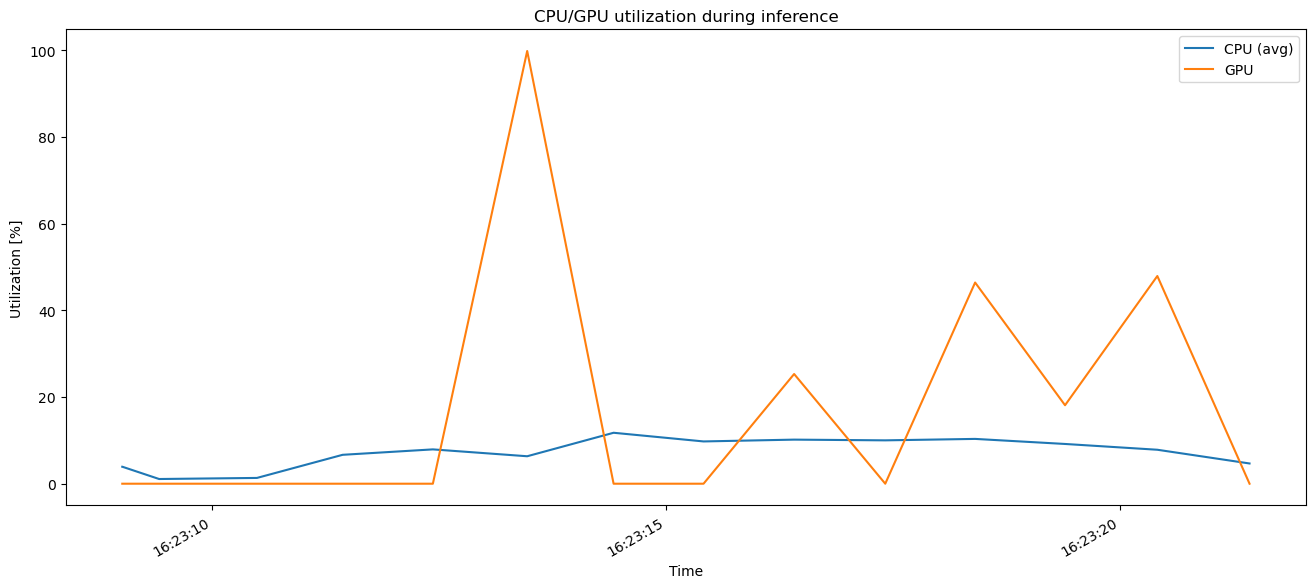

In [10]:
benchmark_results['CPU (avg)'] = benchmark_results[[f'CPU{i+1}' for i in range(12)]].mean(axis=1)

ax = benchmark_results.plot(y=["CPU (avg)", "GPU"], figsize=(16, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.title('CPU/GPU utilization during inference')
plt.xlabel('Time')
plt.ylabel('Utilization [%]')